In [60]:
import gzip
import json
import statistics
from typing import Iterator

import pandas as pd
from plotnine import *
from surprise import (
    accuracy,
    AlgoBase,
    BaselineOnly,
    Dataset,
    KNNBasic,
    KNNWithZScore,
    NormalPredictor,
    Reader,
    SlopeOne,
    SVD,
)
from surprise.model_selection import cross_validate, train_test_split

# Table of Contents

- [Step B.1](#Step-B.1)
- [Step B.2](#Step-B.2)
- [Step B.3](#Step-B.3)
- [Step B.4](#Step-B.4)

In [61]:
# download the “small” 5-core dataset for the category "Digital Music"
# dataset source: https://nijianmo.github.io/amazon/index.html

!wget --backups=1 http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music_5.json.gz -P data/

--2022-02-20 13:51:02--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19408584 (19M) [application/octet-stream]
Saving to: ‘data/Digital_Music_5.json.gz’

Digital_Music_5.jso 100%[===================>]  18.51M   307KB/s    in 69s     

2022-02-20 13:52:12 (273 KB/s) - ‘data/Digital_Music_5.json.gz’ saved [19408584/19408584]



## Step B.1

In [62]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [63]:
def parse(filepath: str) -> Iterator[dict]:
    file_obj = gzip.open(filepath, "rb")
    for line in file_obj:
        yield json.loads(line)

In [64]:
def file_to_dataframe(filepath: str) -> pd.DataFrame:
    i = 0
    df = {}
    for d in parse(filepath):
        df[i] = {
            "user": d["reviewerID"],
            "item": d["asin"],
            "rating": d["overall"],
            "timestamp": d["unixReviewTime"],
        }  # keep only the essential data
        i += 1
    return pd.DataFrame.from_dict(df, orient="index")

In [65]:
review_data = file_to_dataframe("data/Digital_Music_5.json.gz")

In [66]:
reader = Reader(rating_scale=(1, 5))

In [67]:
data = Dataset.load_from_df(review_data[["user", "item", "rating"]], reader)

inspect_df(data.df, 10)

shape: (169781, 3)


,user,item,rating
0,A2TYZ821XXK2YZ,3426958910,5.0
1,A3OFSREZADFUDY,3426958910,5.0
2,A2VAMODP8M77NG,3426958910,5.0
3,AAKSLZ9IDTEH0,3426958910,4.0
4,A3OH43OZJLKI09,5557706259,5.0
5,A6JP9YYJCK3WO,5557706259,4.0
6,A20Z0JD766DPG6,5557706259,5.0
7,AXQ89O6YRT7AX,5557706259,5.0
8,A1M379MK8MKGUF,5557706259,5.0
9,AA762OWLWCPQ2,5557706259,5.0


## Step B.2

In [68]:
cv_results = {}

In [69]:
"""
Algorithm predicting a random rating based on the distribution of the training set, 
which is assumed to be normal.
"""
cv_results["NormalPredictor"] = cross_validate(
    algo=NormalPredictor(), data=data, verbose=True, cv=5
)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8927  0.8982  0.8952  0.8916  0.8958  0.8947  0.0023  
MAE (testset)     0.5917  0.5921  0.5947  0.5954  0.5939  0.5936  0.0014  
Fit time          0.11    0.14    0.14    0.14    0.14    0.13    0.01    
Test time         0.12    0.29    0.12    0.26    0.12    0.18    0.08    


In [70]:
"""
Algorithm predicting the baseline estimate for given user and item.
"""
cv_results["BaselineOnly"] = cross_validate(
    algo=BaselineOnly(), data=data, verbose=True, cv=5
)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5946  0.5919  0.5945  0.5838  0.5914  0.5912  0.0039  
MAE (testset)     0.3714  0.3700  0.3723  0.3677  0.3690  0.3701  0.0016  
Fit time          0.38    0.42    0.44    0.44    0.50    0.44    0.04    
Test time         0.08    0.09    0.08    0.09    0.09    0.09    0.00    


In [71]:
"""
A basic item-item collaborative filtering algorithm.
"""
cv_results["KNNBasic (cosine) item-based"] = cross_validate(
    algo=KNNBasic(
        sim_options={
            "name": "cosine",
            "user_based": False,
        }
    ),
    data=data,
    verbose=True,
    cv=5,
)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6086  0.6220  0.6038  0.6088  0.6051  0.6097  0.0065  
MAE (testset)     0.3124  0.3165  0.3131  0.3128  0.3114  0.3133  0.0017  
Fit time          4.71    4.69    4.75    4.74    5.10    4.80    0.15    
Test time         0.74    0.65    0.56    0.65    0.63    0.65    0.06    


In [72]:
"""
A simple yet accurate item-based collaborative filtering algorithm.

This is a straightforward implementation of the SlopeOne algorithm: https://arxiv.org/abs/cs/0702144
"""
cv_results["SlopeOne"] = cross_validate(
    algo=SlopeOne(),
    data=data,
    verbose=True,
    cv=5,
)

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5731  0.5811  0.5830  0.5948  0.5832  0.5830  0.0069  
MAE (testset)     0.2675  0.2719  0.2735  0.2763  0.2718  0.2722  0.0029  
Fit time          2.69    2.85    2.77    2.73    2.67    2.74    0.06    
Test time         0.52    0.46    0.62    0.49    0.65    0.55    0.08    


In [73]:
"""
A basic user-user collaborative filtering algorithm.
"""
cv_results["KNNBasic (cosine) user-based"] = cross_validate(
    algo=KNNBasic(
        sim_options={
            "name": "cosine",
            "user_based": True,
        }
    ),
    data=data,
    verbose=True,
    cv=5,
)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7740  0.7637  0.7692  0.7786  0.7766  0.7724  0.0054  
MAE (testset)     0.4664  0.4636  0.4652  0.4672  0.4685  0.4662  0.0017  
Fit time          8.59    9.62    8.93    8.72    10.09   9.19    0.57    
Test time         0.83    1.13    0.82    0.94    1.26    1.00    0.17    


In [74]:
"""
A basic collaborative filtering algorithm, taking into account
the z-score normalization of each user.
"""
cv_results["KNNWithZScore (MSD) user-based"] = cross_validate(
    algo=KNNWithZScore(
        sim_options={
            "name": "msd",
            "user_based": True,
        }
    ),
    data=data,
    verbose=True,
    cv=5,
)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5879  0.5896  0.5804  0.5920  0.5922  0.5884  0.0043  
MAE (testset)     0.2877  0.2917  0.2890  0.2946  0.2941  0.2914  0.0027  
Fit time          6.38    6.82    6.90    6.68    6.71    6.70    0.18    
Test time         0.97    1.23    0.99    1.11    0.97    1.05    0.10    


In [75]:
"""
The famous SVD algorithm, as popularized by `Simon Funk
<http://sifter.org/~simon/journal/20061211.html>`_ during the Netflix Prize.
"""
cv_results["KNNWithZScore (MSD) user-based"] = cross_validate(
    algo=SVD(), data=data, verbose=True, cv=5
)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5584  0.5666  0.5577  0.5627  0.5604  0.5611  0.0032  
MAE (testset)     0.3337  0.3388  0.3334  0.3343  0.3372  0.3355  0.0021  
Fit time          5.42    5.47    5.53    5.43    5.33    5.44    0.07    
Test time         0.16    0.14    0.17    0.29    0.15    0.18    0.06    


## Step B.3

In [76]:
df = pd.DataFrame(cv_results).T.reset_index()

df["mean RMSE"] = df["test_rmse"].map(lambda x: statistics.mean(x))

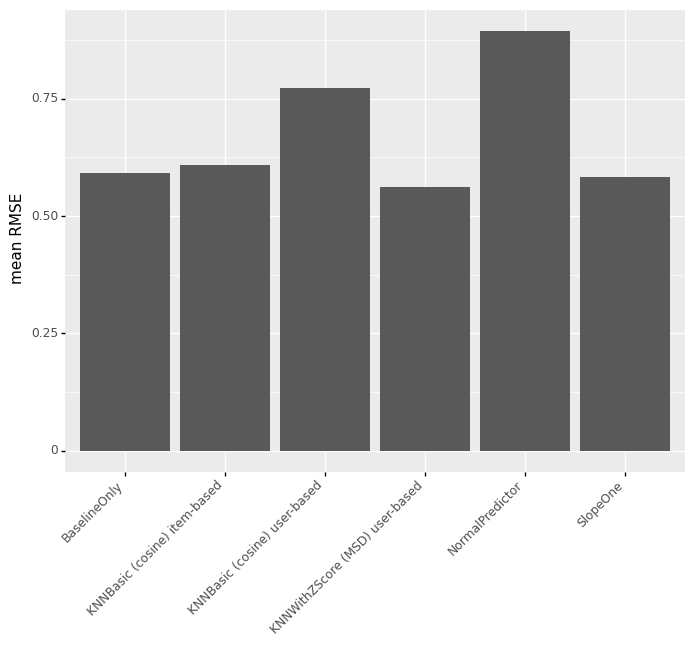

<ggplot: (8744267294603)>

In [77]:
(
    ggplot(df)
    + geom_col(aes(x="index", y="mean RMSE"), stat="identity")
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
    + labs(x="", y="mean RMSE")
)

## Step B.4

In [78]:
trainset, testset = train_test_split(data, test_size=0.25)

In [79]:
recsys = KNNWithZScore(
    sim_options={
        "name": "msd",
        "user_based": True,
    }
).fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [80]:
def get_recommendations_for_user(user: str, rs: AlgoBase, n: int = 5) -> list:

    # get n random unseen products for this user
    unseen_items = review_data[review_data["user"] != user]["item"].sample(n).tolist()

    # recommend
    return [rs.predict(uid=user, iid=item) for item in unseen_items]

In [81]:
users = list(set((u for u, _, _ in testset)))

for user in users[:5]:  # show recommendations for first 5 users, no need to display all
    for recommendation in get_recommendations_for_user(user, rs=recsys, n=5):
        print(recommendation)
    print("=" * 105)

user: A3U6W30C8NV11Y item: B004HLD10E r_ui = None   est = 5.00   {'actual_k': 0, 'was_impossible': False}
user: A3U6W30C8NV11Y item: B00F0AIBJC r_ui = None   est = 4.75   {'actual_k': 2, 'was_impossible': False}
user: A3U6W30C8NV11Y item: B0013805L2 r_ui = None   est = 5.00   {'actual_k': 0, 'was_impossible': False}
user: A3U6W30C8NV11Y item: B004H028IG r_ui = None   est = 5.00   {'actual_k': 0, 'was_impossible': False}
user: A3U6W30C8NV11Y item: B00J9R8PJ8 r_ui = None   est = 5.00   {'actual_k': 0, 'was_impossible': False}
user: AKB8X5WG9OA16 item: B0011Z762I r_ui = None   est = 4.58   {'actual_k': 0, 'was_impossible': False}
user: AKB8X5WG9OA16 item: B000TE6KXS r_ui = None   est = 4.58   {'actual_k': 0, 'was_impossible': False}
user: AKB8X5WG9OA16 item: B00KX09DMI r_ui = None   est = 4.58   {'actual_k': 1, 'was_impossible': False}
user: AKB8X5WG9OA16 item: B000WKT6B2 r_ui = None   est = 4.46   {'actual_k': 1, 'was_impossible': False}
user: AKB8X5WG9OA16 item: B00136Q05O r_ui = None  